In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from time import sleep
from tqdm import tqdm
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
from math import cos, sin, pi
import numpy as np
from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result, trajectory_polar_comparison,find_ideal_R, position_finder_mean
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, move_stage, beat_to_center, center_object, optimal_z_position
import csv
import random
import os
import json
import pycromanager
#from pipython.datarectools import getservotime
import cv2
#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

C:\Users\jschulz\AppData\Local\Temp\ipykernel_23444\587672327.py:22: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [3]:
os.listdir(r'\\134.76.13.158\betzlab\Julian\\Hydrogel\\measurement_2')

['10_khz',
 '10_khz_Export_20231006_112401.avi',
 '1_khz',
 '1_khz_Export_20231006_104624.avi',
 '25_khz',
 '25_khz_Export_20231006_140921.avi',
 '50_khz_Export_20231006_121201.avi',
 '5_khz',
 '5_khz_Export_20231006_105529.avi']

In [4]:
file_path = r'\\134.76.13.158\betzlab\Julian\\Hydrogel\\measurement_2\\50_khz_Export_20231006_121201.avi'

In [5]:
def movie_to_array(video_path, channel=0, max_frames=None):
    """
    Convert a movie to a numpy array with the option to truncate the movie.
    """

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_slices = []

    if max_frames is not None:
        total_frames = min(total_frames, max_frames)

    # Add tqdm progress bar
    test_image = cap.read()[1]
    threshold = 0#most_common_value(test_image[2:, :, channel].flatten())+3

    for _ in tqdm(range(total_frames), desc="Processing video", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        image = frame[1:-2, :, channel]
        image[image<threshold] = threshold
        image = image - threshold

        frame_slices.append(image)

    cap.release()

    # Adjust the dimensions so that movie[0] is the first frame
    return np.array(frame_slices).astype(np.int32)

In [6]:
def plot_pixel_occurences(image,value):
    # Create mask where image is 24
    mask_24 = (image == value)

    # Create even and odd masks
    even_rows_mask = np.zeros_like(image, dtype=bool)
    odd_rows_mask = np.zeros_like(image, dtype=bool)

    even_rows_mask[::2] = mask_24[::2]
    odd_rows_mask[1::2] = mask_24[1::2]

    # Combine masks with different values for visualization
    combined_mask = np.zeros_like(image, dtype=int)
    combined_mask[even_rows_mask] = 1
    combined_mask[odd_rows_mask] = 2

    # Use a colormap where:
    # 0 (background) is white, 
    # 1 (even rows) is one color (e.g., red),
    # 2 (odd rows) is another color (e.g., blue)
    cmap = plt.cm.colors.ListedColormap(['white', 'red', 'blue'])
    plt.figure(figsize=(10, 5))
    plt.imshow(combined_mask, cmap=cmap)
    plt.title(f'Pixel Occurrences of {value}')
    #plt.colorbar(ticks=[0, 1, 2], values=['Not 24', '24 in Even Rows', '24 in Odd Rows'])
    plt.show()

In [8]:
numpy_movie = movie_to_array(file_path,max_frames=100)

Processing video: 100%|██████████| 100/100 [00:00<00:00, 1121.47frame/s]


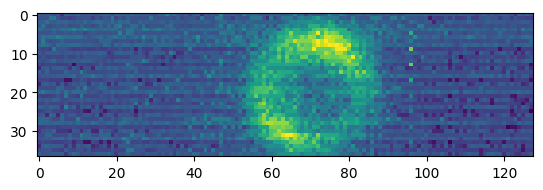

In [9]:
image = numpy_movie[0]
plt.imshow(image)

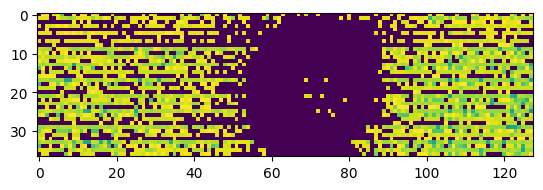

Mean of even rows: 23.24939172749392
Mean of odd rows: 22.38555030384875


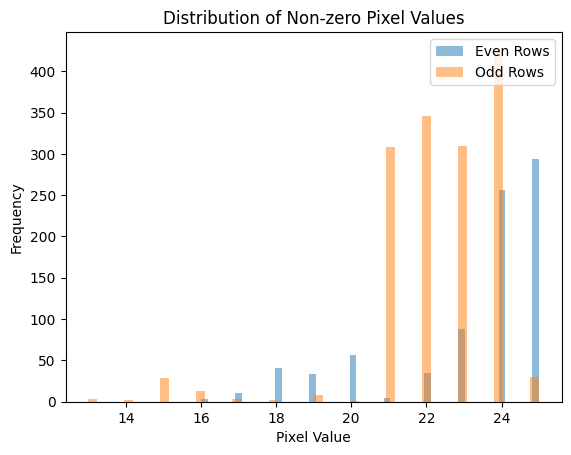

P-value for difference: 5.7932442111628086e-21
The difference is statistically significant.


In [67]:
from scipy.stats import ttest_ind


image_background = np.where(image < 26, image, 0)
plt.imshow(image_background)
plt.show()

# Extract non-zero values from even and odd rows
even_rows_nonzero = image_background[::2][image_background[::2] != 0]
odd_rows_nonzero = image_background[1::2][image_background[1::2] != 0]

# Compute mean
mean_of_even_rows = np.mean(even_rows_nonzero)
mean_of_odd_rows = np.mean(odd_rows_nonzero)
print(f"Mean of even rows: {mean_of_even_rows}")
print(f"Mean of odd rows: {mean_of_odd_rows}")

# Plot histograms
plt.hist(even_rows_nonzero, bins=50, alpha=0.5, label='Even Rows')
plt.hist(odd_rows_nonzero, bins=50, alpha=0.5, label='Odd Rows')
plt.legend(loc='upper right')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-zero Pixel Values')
plt.show()

# Test for significance
t_stat, p_value = ttest_ind(even_rows_nonzero, odd_rows_nonzero, equal_var=False)
print(f"P-value for difference: {p_value}")

# Check for significance at 0.05 level
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

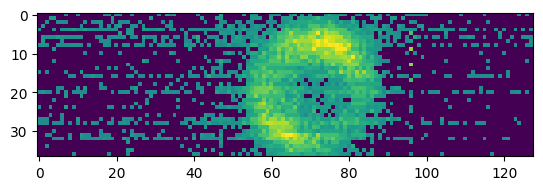

Mean of even rows: 32.27633851468048
Mean of odd rows: 34.65331664580726


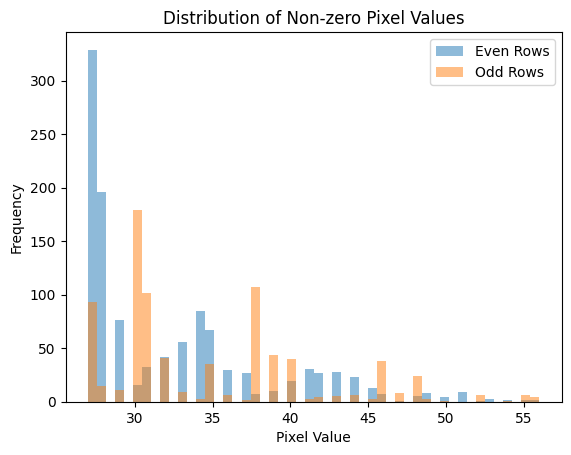

P-value for difference: 1.8047460220049124e-15
The difference is statistically significant.


In [68]:

image_foreground = np.where(image > 26, image, 0)
plt.imshow(image_foreground)
plt.show()

# Extract non-zero values from even and odd rows
even_rows_nonzero = image_foreground[::2][image_foreground[::2] != 0]
odd_rows_nonzero = image_foreground[1::2][image_foreground[1::2] != 0]

# Compute mean
mean_of_even_rows = np.mean(even_rows_nonzero)
mean_of_odd_rows = np.mean(odd_rows_nonzero)
print(f"Mean of even rows: {mean_of_even_rows}")
print(f"Mean of odd rows: {mean_of_odd_rows}")

# Plot histograms
plt.hist(even_rows_nonzero, bins=50, alpha=0.5, label='Even Rows')
plt.hist(odd_rows_nonzero, bins=50, alpha=0.5, label='Odd Rows')
plt.legend(loc='upper right')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-zero Pixel Values')
plt.show()

# Test for significance
t_stat, p_value = ttest_ind(even_rows_nonzero, odd_rows_nonzero, equal_var=False)
print(f"P-value for difference: {p_value}")

# Check for significance at 0.05 level
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

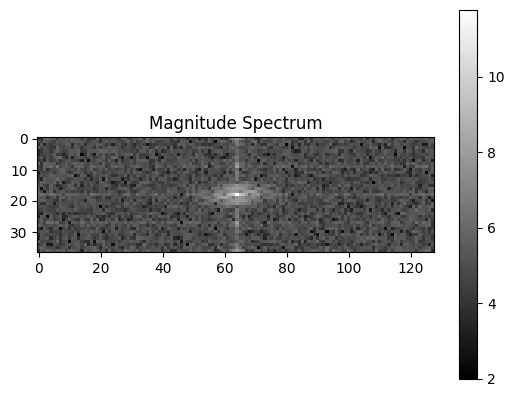

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Perform 2D Fourier Transform
f_transform = np.fft.fft2(image)

# Shift the zero-frequency component to the center
f_transform_centered = np.fft.fftshift(f_transform)

# Compute the magnitude spectrum and use logarithmic scale for better visualization
magnitude_spectrum = np.log(np.abs(f_transform_centered) + 1)

# Display the magnitude spectrum
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()

In [82]:
import numpy as np
import matplotlib.pyplot as plt





def show_fourier_mask(image,  band_width):
    # Assuming your 'image' variable is already loaded

    # Perform 2D Fourier Transform
    f_transform = np.fft.fft2(image)

    # Shift the zero-frequency component to the center
    f_transform_centered = np.fft.fftshift(f_transform)

    # Copy for visualization later
    f_transform_centered_visual = np.copy(f_transform_centered)

    # Mask out the high-frequency oscillations due to even-odd row differences near the top and bottom
    rows, cols = image.shape

    replacement_value = np.median(f_transform_centered)

    f_transform_centered[:band_width, :] = replacement_value
    f_transform_centered[-band_width:, :] = replacement_value
    print(np.median(f_transform_centered))

    # Mark the areas put to 0 in the visualization copy with a red box
    f_transform_centered_visual[:band_width, :] = np.max(f_transform_centered_visual)
    f_transform_centered_visual[-band_width:, :] = np.max(f_transform_centered_visual)

    # Compute the magnitude spectrum for visualization
    magnitude_spectrum = np.log(np.abs(f_transform_centered_visual) + 1)

    # Shift back the zero-frequency component to the top-left corner
    f_transform_filtered = np.fft.ifftshift(f_transform_centered)

    # Perform Inverse 2D Fourier Transform to get the filtered image
    filtered_image = np.real(np.fft.ifft2(f_transform_filtered))

    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')

    # Fourier transform with red box
    axs[1].imshow(magnitude_spectrum, cmap='gray')
    axs[1].set_title('Fourier Transform')
    axs[1].add_patch(plt.Rectangle((0, 0), cols, band_width, color='red', fill=False))
    axs[1].add_patch(plt.Rectangle((0, rows - band_width), cols, band_width, color='red', fill=False))

    # Filtered image
    axs[2].imshow(filtered_image, cmap='gray')
    axs[2].set_title('Filtered Image')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return magnitude_spectrum

(0.6021449409520852+33.31467684687186j)


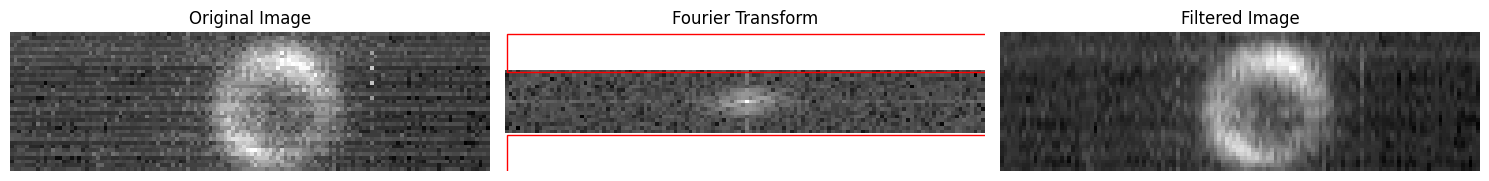

In [83]:
filtered_image =show_fourier_mask(image,10)

In [54]:
filtered_image

array([[12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259],
       [12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259],
       [12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259],
       ...,
       [12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259],
       [12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259],
       [12.13301259, 12.13301259, 12.13301259, ..., 12.13301259,
        12.13301259, 12.13301259]])

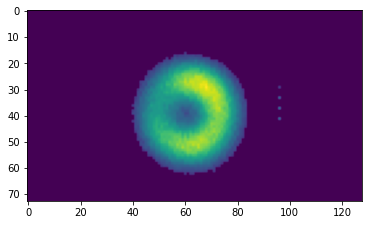

Mean of even rows: 84.97590321703522
Mean of odd rows: 84.20802572964358


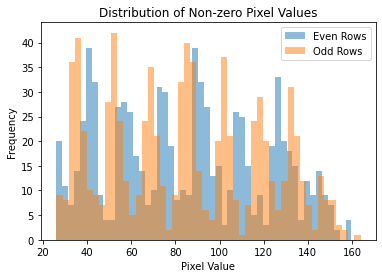

P-value for difference: 0.6608778894756379
The difference is not statistically significant.


In [240]:

image_foreground = np.where(filtered_image > 26, filtered_image, 0)
plt.imshow(image_foreground)
plt.show()

# Extract non-zero values from even and odd rows
even_rows_nonzero = image_foreground[::2][image_foreground[::2] != 0]
odd_rows_nonzero = image_foreground[1::2][image_foreground[1::2] != 0]

# Compute mean
mean_of_even_rows = np.mean(even_rows_nonzero)
mean_of_odd_rows = np.mean(odd_rows_nonzero)
print(f"Mean of even rows: {mean_of_even_rows}")
print(f"Mean of odd rows: {mean_of_odd_rows}")

# Plot histograms
plt.hist(even_rows_nonzero, bins=50, alpha=0.5, label='Even Rows')
plt.hist(odd_rows_nonzero, bins=50, alpha=0.5, label='Odd Rows')
plt.legend(loc='upper right')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-zero Pixel Values')
plt.show()

# Test for significance
t_stat, p_value = ttest_ind(even_rows_nonzero, odd_rows_nonzero, equal_var=False)
print(f"P-value for difference: {p_value}")

# Check for significance at 0.05 level
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

In [241]:
def log_comb(n, k):
    # Using Stirling's approximation for large factorials:
    log_n_fact = n * np.log(n) - n
    log_k_fact = k * np.log(k) - k
    log_n_minus_k_fact = (n - k) * np.log(n - k) - (n - k)
    
    return log_n_fact - (log_k_fact + log_n_minus_k_fact)

def binomial_probability(N, K, N_odd):
    # Calculate the combined probability p
    p = K / N

    # Calculate the logarithm of the probability using the binomial distribution
    log_probability = (log_comb(int(N/2), int(N_odd)) + 
                       N_odd * np.log(p) + 
                       (int(N/2) - N_odd) * np.log(1-p))

    return np.exp(log_probability)

def check_pixel_significance(image, significance_level=0.05):
    # Flatten the image into a 1D array
    flat_image = image.flatten()

    # Extract even and odd rows
    even_rows = image[0::2].flatten()
    odd_rows = image[1::2].flatten()

    # Get unique pixel values
    unique_pixel_values = np.unique(flat_image)

    significant_values = []

    N = len(flat_image)

    for pixel_value in unique_pixel_values:
        # Count occurrences of this pixel value in the whole image, even and odd rows
        K = np.sum(flat_image == pixel_value)
        N_odd = np.sum(odd_rows == pixel_value)

        #print(f"Pixel value: {pixel_value}, K: {K}, N_odd: {N_odd}")

        # Calculate the binomial probability for this pixel value
        p_value = binomial_probability(N, K, N_odd)

        if p_value < significance_level:
            significant_values.append(pixel_value)

    return significant_values

In [242]:
significant_values = check_pixel_significance(image, significance_level=0.001)

C:\Users\BETZLA~1\AppData\Local\Temp/ipykernel_15144/3738563017.py:4: RuntimeWarning: divide by zero encountered in log
  log_k_fact = k * np.log(k) - k
C:\Users\BETZLA~1\AppData\Local\Temp/ipykernel_15144/3738563017.py:4: RuntimeWarning: invalid value encountered in double_scalars
  log_k_fact = k * np.log(k) - k


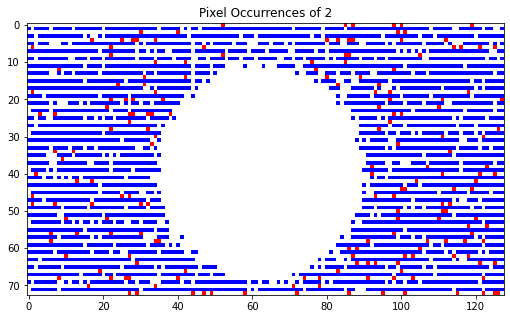

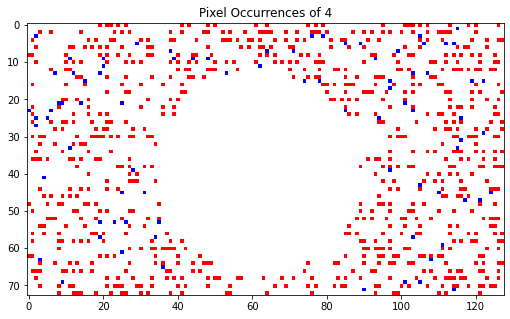

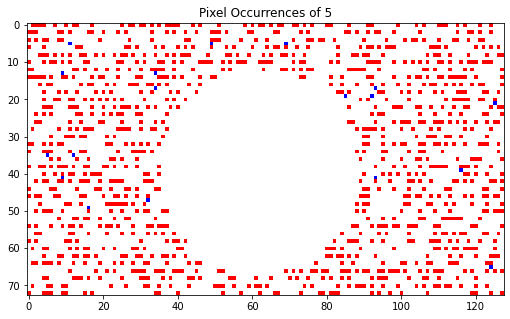

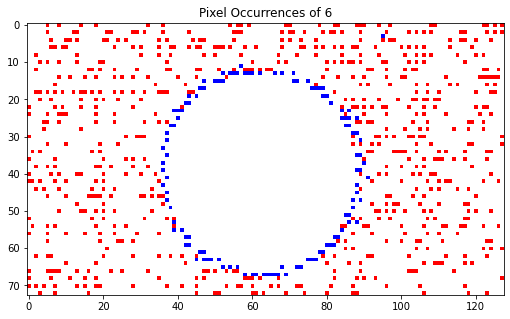

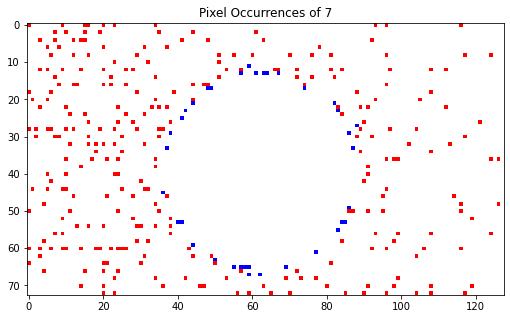

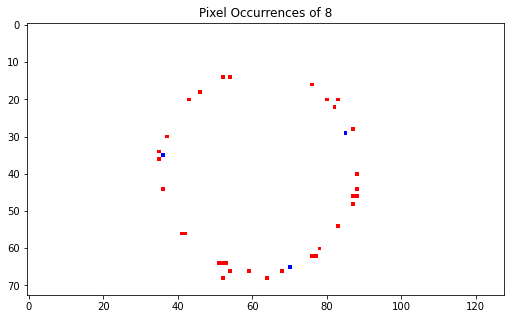

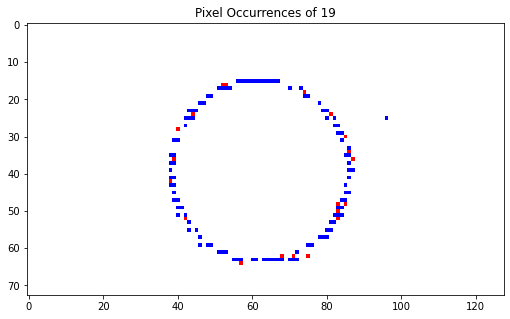

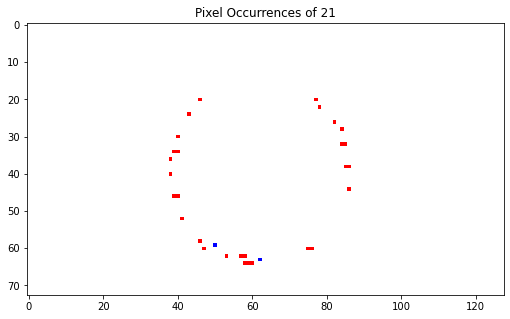

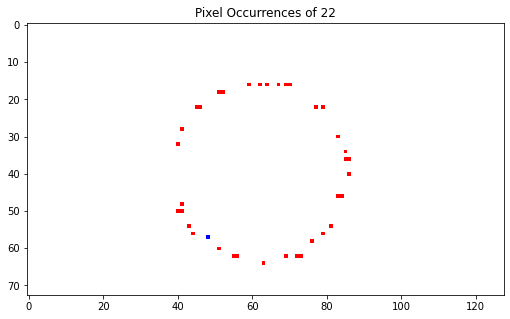

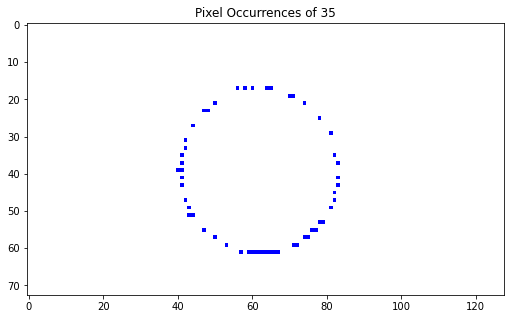

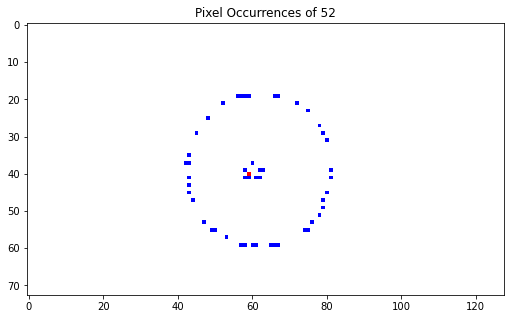

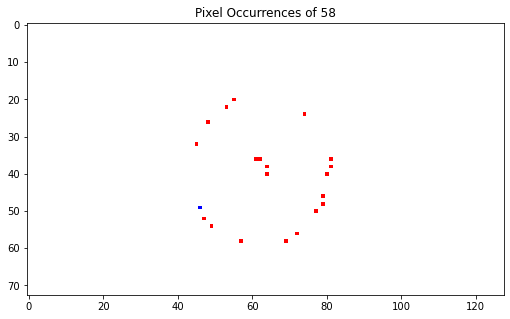

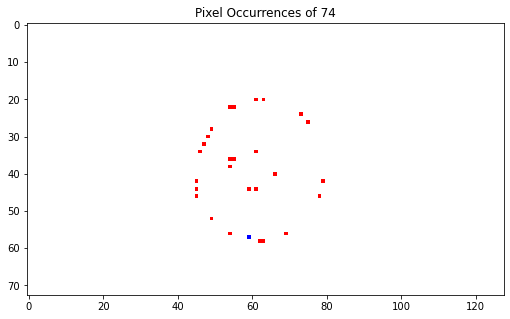

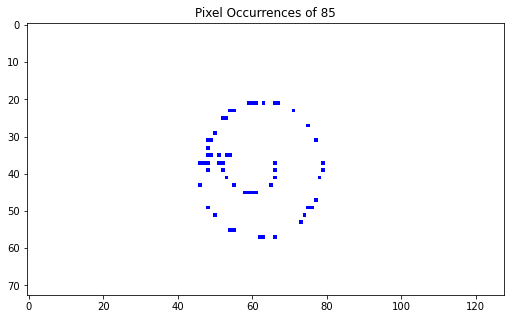

In [243]:
for value in significant_values:
    plot_pixel_occurences(image,value)

In [244]:
image_even = image[::2]
image_odd = image[1::2]

In [245]:
from scipy.interpolate import interp1d

def interpolate_image_rows(part_image):
    # Number of rows and columns
    num_rows, num_cols = part_image.shape

    # Create an output image of double the size
    interpolated_image = np.zeros((num_rows * 2, num_cols))

    # Fill in every second row of the output image with the original rows
    interpolated_image[::2] = part_image

    # Create a 1D linear interpolation function for each column
    for col in range(num_cols):
        valid_rows = np.arange(0, 2*num_rows, 2)
        interpolator = interp1d(valid_rows, part_image[:, col], kind="linear", fill_value="extrapolate")

        # Interpolate the missing rows for the current column
        missing_rows = np.arange(1, 2*num_rows, 2)
        interpolated_image[missing_rows, col] = interpolator(missing_rows)

    return interpolated_image

# Interpolate the even and odd parts
interpolated_even = interpolate_image_rows(image_even)[1:-1]
interpolated_odd = interpolate_image_rows(image_odd)

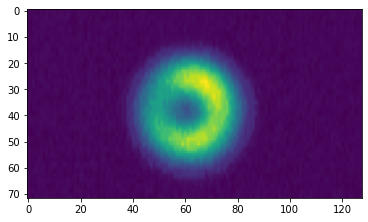

In [246]:
plt.imshow(interpolated_even)

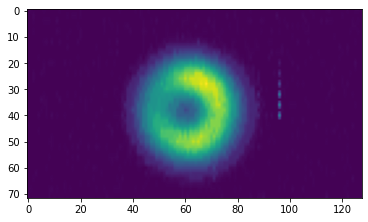

In [247]:
plt.imshow(interpolated_odd)

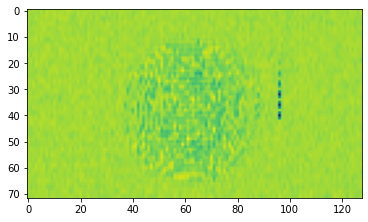

In [248]:
plt.imshow(interpolated_even-interpolated_odd)

In [249]:
import numpy as np

def estimate_odd_pixels(image):
    # Lists to store the actual odd-rowed pixel values and their estimates
    actual_values = []
    estimated_values = []
    
    rows, cols = image.shape
    
    # Iterate over every pixel in an odd row
    for i in range(1, rows, 2):
        for j in range(cols):
            actual_values.append(image[i, j])
            
            # Calculate the weighted average of the surrounding even-rowed pixels
            if 0 < j < cols-1:
                estimated_value = (2*image[i-1, j] + image[i-1, j-1] + image[i-1, j+1] + 2*image[i+1, j]) / 6.0
            elif j == 0:
                estimated_value = (2*image[i-1, j] + image[i-1, j+1] + 2*image[i+1, j]) / 5.0
            else:  # j == cols-1
                estimated_value = (2*image[i-1, j] + image[i-1, j-1] + 2*image[i+1, j]) / 5.0

            estimated_values.append(estimated_value)
    
    return actual_values, estimated_values

# Usage
actual, estimated = estimate_odd_pixels(image)


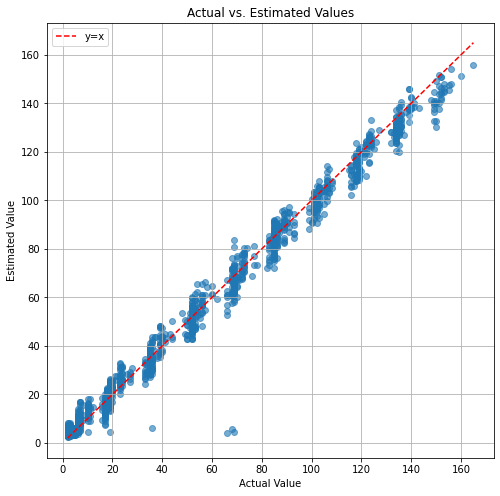

In [250]:
# Assuming you've already called the `estimate_odd_pixels` function and have 'actual' and 'estimated' lists
actual, estimated = estimate_odd_pixels(image)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(actual, estimated, alpha=0.6)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--', label="y=x")  # y=x line for reference
plt.title("Actual vs. Estimated Values")
plt.xlabel("Actual Value")
plt.ylabel("Estimated Value")
plt.legend()
plt.grid(True)
plt.show()

In [251]:
from collections import defaultdict, Counter

# Assuming you've already called the `estimate_odd_pixels` function and have 'actual' and 'estimated' lists
actual, estimated = estimate_odd_pixels(image)

# Count occurrences of each unique value in 'actual'
value_counts = Counter(actual)

# Filter values that occur more than 10 times
frequent_values = [value for value, count in value_counts.items() if count > 10]

# Create a dictionary to store the sum of estimated values for each actual value
estimated_sums = defaultdict(float)

# Create a dictionary to store the count of estimated values for each actual value
estimated_counts = defaultdict(int)

# Populate the dictionaries
for a, e in zip(actual, estimated):
    if a in frequent_values:
        estimated_sums[a] += e
        estimated_counts[a] += 1

# Calculate average estimated values for each frequent actual value
value_map = {a: estimated_sums[a] / estimated_counts[a] for a in frequent_values}

print(value_map)


{2: 4.693307861526004, 3: 4.913285600636438, 4: 4.719341563786006, 6: 7.737068965517244, 5: 4.472222222222221, 7: 9.921296296296298, 17: 13.676470588235293, 19: 19.7057057057057, 10: 12.704545454545455, 23: 26.252873563218383, 35: 34.39506172839507, 33: 29.59090909090909, 36: 33.174603174603185, 24: 27.575757575757578, 18: 18.761904761904756, 20: 22.552083333333332, 39: 42.08888888888889, 52: 51.52380952380952, 56: 57.42222222222223, 53: 53.54761904761905, 69: 65.27272727272725, 85: 83.07878787878789, 89: 89.77777777777779, 86: 85.675, 72: 71.9090909090909, 68: 63.81818181818183, 101: 97.85087719298245, 118: 113.94666666666667, 119: 115.14035087719303, 103: 101.72619047619048, 70: 68.83333333333331, 73: 75.15384615384616, 102: 99.87121212121214, 136: 133.59090909090912, 135: 130.52173913043478, 134: 128.4942528735632, 123: 123.09722222222223, 106: 106.64285714285714, 83: 79.71212121212122}


In [252]:
import numpy as np
from collections import defaultdict, Counter

def estimate_movie_values(movie):
    """
    Estimate values for odd-row pixels from a movie (3D numpy array).
    
    Parameters:
    - movie: A 3D numpy array representing a series of 2D frames.

    Returns:
    - A dictionary mapping actual pixel values to their average estimated values.
    """
    
    def estimate_pixel(frame, i, j):
        """
        Estimate the value of a pixel in an odd row of a 2D frame.
        
        Parameters:
        - frame: A 2D numpy array (a frame from the movie).
        - i, j: Indices of the pixel to estimate.

        Returns:
        - The estimated value of the pixel.
        """
        surrounding = []
        
        # Above pixel (if exists)
        if i > 0:
            surrounding.append(frame[i-1, j])
        
        # Below pixel (if exists)
        if i < frame.shape[0] - 1:
            surrounding.append(frame[i+1, j])

        return np.mean(surrounding)

    # Count the occurrences of each pixel value
    value_counts = Counter()
    estimated_values = defaultdict(list)

    # Loop over each frame in the movie
    for frame in movie:
        
        # Iterate only odd rows (1, 3, 5, ...)
        for i in range(1, frame.shape[0], 2):
            
            for j in range(frame.shape[1]):
                pixel_value = frame[i, j]
                
                if value_counts[pixel_value] < 1000:
                    estimated = estimate_pixel(frame, i, j)
                    estimated_values[pixel_value].append(estimated)
                    
                value_counts[pixel_value] += 1

    # Calculate average for each pixel value
    for key, values in estimated_values.items():
        estimated_values[key] = np.mean(values)

    return estimated_values

# Test with a movie (3D numpy array)
# movie = np.random.randint(0, 255, (10, 100, 100))  # 10 frames of 100x100 pixels
# value_map = estimate_movie_values(movie)
# print(value_map)

def translate_odd_rows(movie, estimated_values):
    """
    Translates the values of the odd-rowed pixels in the movie using the given estimated values.
    
    Parameters:
    - movie: A 3D numpy array representing a series of 2D frames.
    - estimated_values: A dictionary mapping actual pixel values to their average estimated values.

    Returns:
    - The translated movie with updated odd-row pixel values.
    """
    
    # Create a copy of the movie to avoid modifying the original
    translated_movie = np.copy(movie)

    # Loop over each frame in the movie
    for frame in translated_movie:
        
        # Iterate only odd rows (1, 3, 5, ...)
        for i in range(1, frame.shape[0], 2):
            
            for j in range(frame.shape[1]):
                pixel_value = frame[i, j]
                
                # Check if this pixel value has an estimated value
                if pixel_value in estimated_values:
                    frame[i, j] = estimated_values[pixel_value]

    return translated_movie



In [253]:
estimated_values=estimate_movie_values(numpy_movie)

In [254]:
translated_movie = translate_odd_rows(numpy_movie, estimated_values)

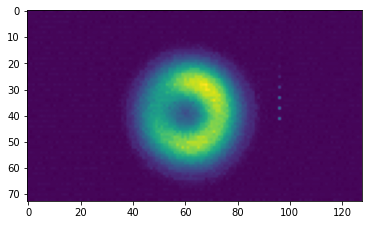

In [255]:
plt.imshow(translated_movie[0])

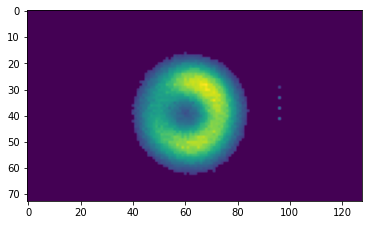

Mean of even rows: 84.31345177664974
Mean of odd rows: 82.67293233082707


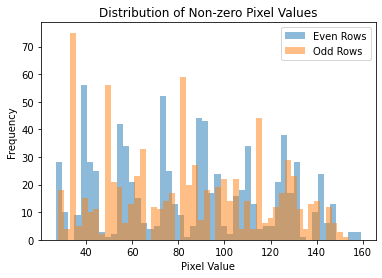

P-value for difference: 0.339719367300772
The difference is not statistically significant.


In [256]:
image = translated_movie[0]
image_foreground = np.where(image > 26, image, 0)
plt.imshow(image_foreground)
plt.show()

# Extract non-zero values from even and odd rows
even_rows_nonzero = image_foreground[::2][image_foreground[::2] != 0]
odd_rows_nonzero = image_foreground[1::2][image_foreground[1::2] != 0]

# Compute mean
mean_of_even_rows = np.mean(even_rows_nonzero)
mean_of_odd_rows = np.mean(odd_rows_nonzero)
print(f"Mean of even rows: {mean_of_even_rows}")
print(f"Mean of odd rows: {mean_of_odd_rows}")

# Plot histograms
plt.hist(even_rows_nonzero, bins=50, alpha=0.5, label='Even Rows')
plt.hist(odd_rows_nonzero, bins=50, alpha=0.5, label='Odd Rows')
plt.legend(loc='upper right')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-zero Pixel Values')
plt.show()

# Test for significance
t_stat, p_value = ttest_ind(even_rows_nonzero, odd_rows_nonzero, equal_var=False)
print(f"P-value for difference: {p_value}")

# Check for significance at 0.05 level
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

C:\Users\jschulz\AppData\Local\Temp\ipykernel_23444\3681181676.py:9: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  gray_image = face(gray=True)


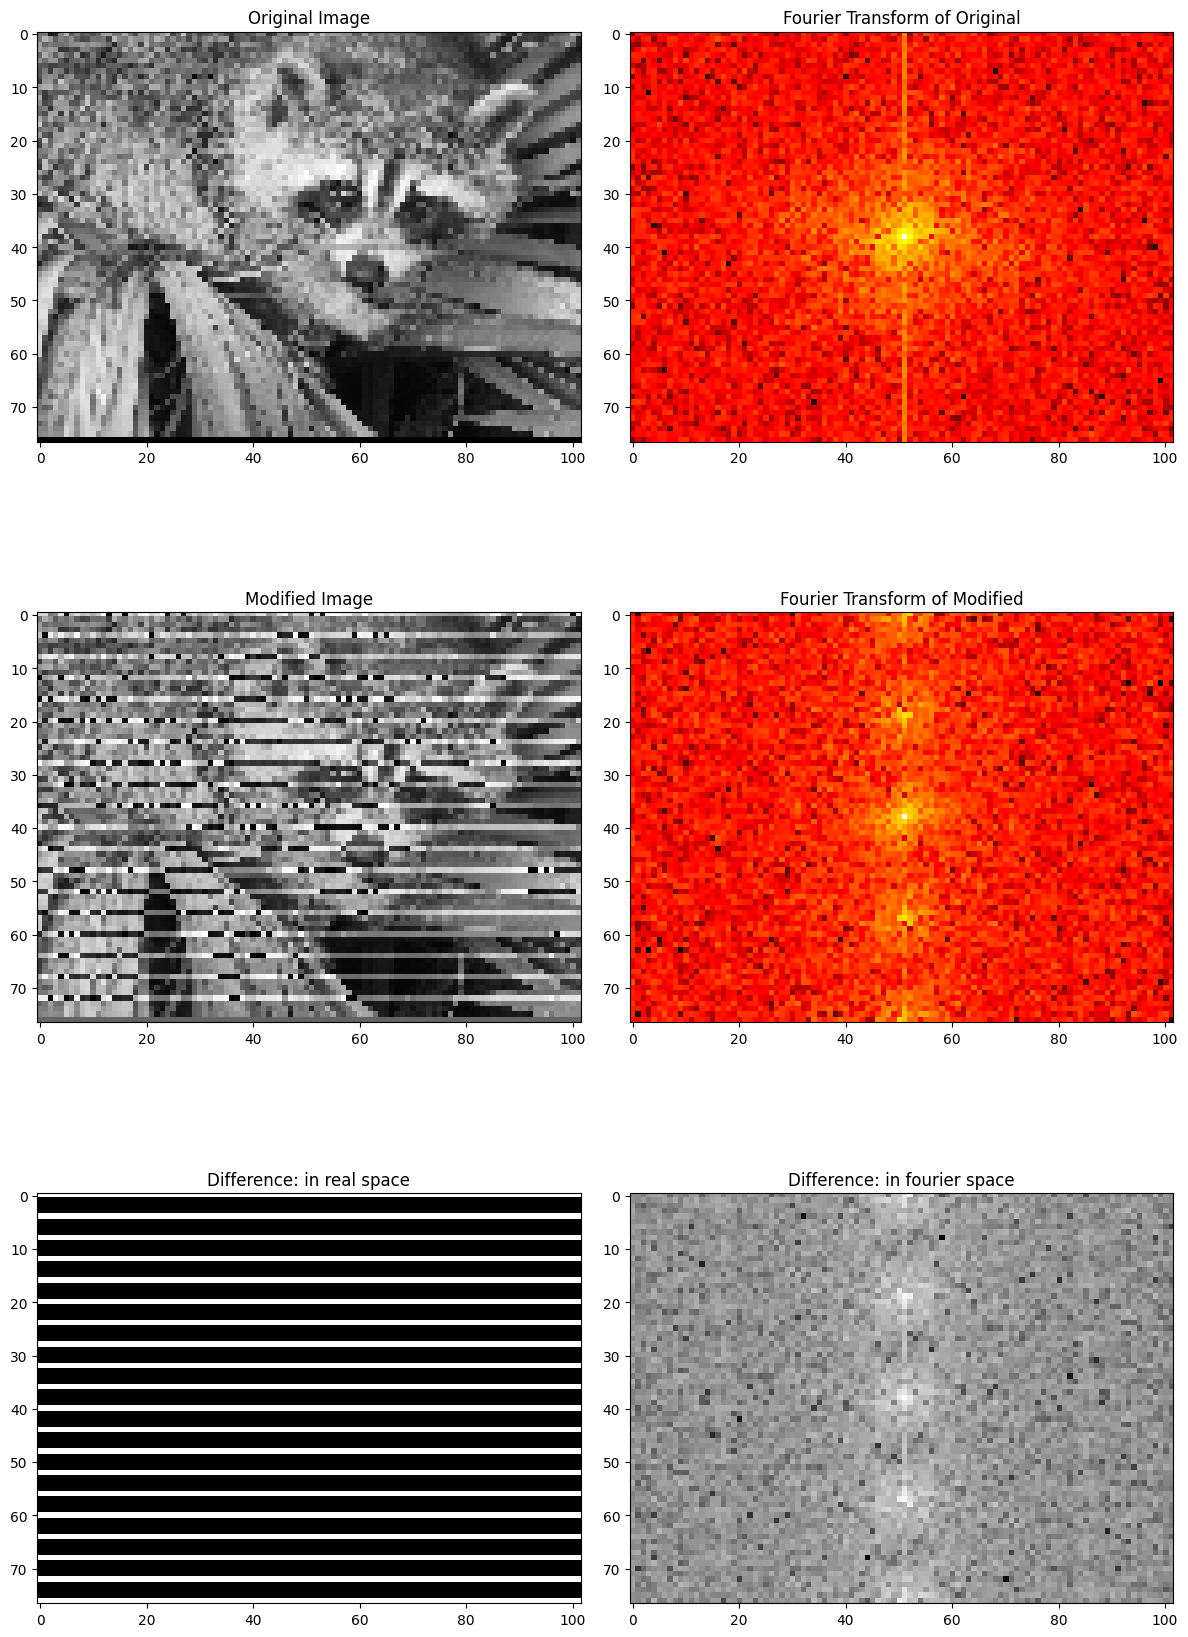

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import face
from scipy.fftpack import fftshift, fft2
from scipy.ndimage import zoom


# Load the image from Scipy
gray_image = face(gray=True)

# Downsample the image by a factor
factor = 0.1  # Adjust this as desired, e.g., 0.25 will reduce the size to 25% of the original
gray_image = zoom(gray_image, factor, order=3)

# Modify the image by adding a constant to every second row
modified_image = gray_image.copy()
modified_image[::4] += 100  # Adjust 50 as desired

# Compute Fourier Transforms
original_ft = fftshift(fft2(gray_image))
modified_ft = fftshift(fft2(modified_image))

# Compute the differences
picture_diff = modified_image- gray_image 
fourier_diff = original_ft - modified_ft


# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

axes[0, 0].imshow(gray_image, cmap='gray')
axes[0, 0].set_title("Original Image")

axes[1, 0].imshow(modified_image, cmap='gray')
axes[1, 0].set_title("Modified Image")

axes[0, 1].imshow(np.log(1 + np.abs(original_ft)), cmap='hot')
axes[0, 1].set_title("Fourier Transform of Original")

axes[1, 1].imshow(np.log(1 + np.abs(modified_ft)), cmap='hot')
axes[1, 1].set_title("Fourier Transform of Modified")

axes[2, 0].imshow(picture_diff, cmap='gray')
axes[2, 0].set_title("Difference: in real space")

axes[2, 1].imshow(np.log(1 + np.abs(fourier_diff)), cmap='gray')
axes[2, 1].set_title("Difference: in fourier space")

plt.tight_layout()
plt.show()